In [1]:
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.optim as optim
import yaml
from torch.nn.parallel import DistributedDataParallel as DDP
import sys, os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributed as dist
import torch.multiprocessing as mp
import torchvision
import torchvision.transforms as transforms
from torch.nn.parallel import DistributedDataParallel
from torch.utils.data import Dataset
import torch.optim as optim
# root_dir = '/mnt/home/spandey/ceph/CHARM/'
# os.chdir(root_dir)
import pickle as pk
# sys.path.append(root_dir)
# sys.path.append(root_dir)
import pathlib
curr_path = pathlib.Path().absolute()
src_path = os.path.abspath(curr_path / "../src/") 
sys.path.append(src_path)

from combined_models import *
from all_models import *
from utils_data_prep_cosmo_vel import *
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}
cosmo = cosmology.setCosmology('myCosmo', **params)
from colossus.lss import mass_function
from tqdm import tqdm
import sparse
import numpy as np
import h5py as h5
import torch
from torch.nn import functional as F
from dataclasses import dataclass
from contextlib import nullcontext
from dataclasses import dataclass
from torch.nn.parallel import DistributedDataParallel as DDP
import matplotlib.pyplot as pl

import os
%load_ext autoreload
%autoreload 2
%matplotlib inline


def setup(rank, world_size):
    # initialize the process group
    dist.init_process_group("nccl", rank=rank, world_size=world_size)

def cleanup():
    dist.destroy_process_group()


def get_data_split(dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed, delta_box_all_squeezed, n1_fac=0.8, n2_fac=1.0):
    n1 = int(n1_fac*len(dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed))
    n2 = int(n2_fac*len(dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed))
    train_data_halos = dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed[:n1]
    val_data_halos = dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed[n1:n2]

    train_data_dm = delta_box_all_squeezed[:n1]
    val_data_dm = delta_box_all_squeezed[n1:n2]

    x = torch.tensor(train_data_halos[:, :-1])
    y = torch.tensor(train_data_halos[:, 1:])
    dm = torch.tensor(train_data_dm)
    mask_train_orig = x != 1
    mask_train = torch.logical_not(mask_train_orig)
    masked_logits = torch.zeros(mask_train.shape)
    mask_train_final = masked_logits.masked_fill(mask_train, float('-inf'))
    mask_train = mask_train_final[:,None,:]
    x, y = torch.tensor(x), torch.tensor(y)
    x_train = x.long()
    y_train = y.long()
    dm_train = dm.bfloat16()
    mask_train = torch.tensor(mask_train).bfloat16()

    x = torch.tensor(val_data_halos[:, :-1])
    y = torch.tensor(val_data_halos[:, 1:])
    dm = torch.tensor(val_data_dm)
    mask_val_orig = x != 1
    mask_val = torch.logical_not(mask_val_orig)
    masked_logits = torch.zeros(mask_val.shape)
    mask_val_final = masked_logits.masked_fill(mask_val, float('-inf'))
    mask_val = mask_val_final[:,None,:]
    x, y = torch.tensor(x), torch.tensor(y)
    x_val = x.long()
    y_val = y.long()
    dm_val = dm.bfloat16()
    mask_val = torch.tensor(mask_val).bfloat16()

    return x_train, y_train, dm_train, mask_train, x_val, y_val, dm_val, mask_val

run_config_name = 'TRAIN_MASS_FREECOSMO_cond_fastpm_ns128.yaml'
with open("/mnt/home/spandey/ceph/CHARM/run_configs/" + run_config_name,"r") as file_object:
    config=yaml.load(file_object,Loader=yaml.SafeLoader)




config_sims = config['sim_settings']
ji_array = np.arange(int(config_sims['nsims']))
nsubvol_per_ji = int(config_sims['nsubvol_per_ji'])
nsubvol_fid = int(config_sims['nsubvol_fid'])
subsel_criteria = config_sims['subsel_criteria']
num_cosmo_params = int(config_sims['num_cosmo_params'])
ns_d = config_sims['ns_d']
nb = config_sims['nb']
nax_d =  ns_d // nb
nf = config_sims['nf']
layers_types = config_sims['layers_types']
z_inference = config_sims['z_inference']
nc = 0
for jl in range(len(layers_types)):
    if layers_types[jl] == 'cnn':
        nc += 1
    elif layers_types[jl] == 'res':
        nc += 2
    else:
        raise ValueError("layer type not supported")

z_all = config_sims['z_all']
z_all_FP = config_sims['z_all_FP']

ns_h = config_sims['ns_h']
nax_h = ns_h // nb
cond_sim = config_sims['cond_sim']

nsims_per_batch = config_sims['nsims_per_batch']
nbatches_train = config_sims['nbatches_train']

mass_type = config_sims['mass_type']
lgMmin = config_sims['lgMmin']
lgMmax = config_sims['lgMmax']
stype = config_sims['stype']
rescale_sub = config_sims['rescale_sub']
lgMmincutstr = config_sims['lgMmincutstr']
# subsel_highM1 = config_sims['subsel_highM1']
# nsubsel = config_sims['nsubsel']
is_HR = config_sims['is_HR']

try:
    Nmax = config_sims['Nmax']
except:
    Nmax = 4

config_net = config['network_settings']
hidden_dim_MAF = config_net['hidden_dim_MAF']
learning_rate = config_net['learning_rate']
K_M1 = config_net['K_M1']
B_M1 = config_net['B_M1']
nflows_M1_NSF = config_net['nflows_M1_NSF']
add_Ntot_cond_for_M1 = config_net['add_Ntot_cond_for_M1']

K_Mdiff = config_net['K_Mdiff']
B_Mdiff = config_net['B_Mdiff']
nflows_Mdiff_NSF = config_net['nflows_Mdiff_NSF']
add_Ntot_M1_cond_for_Mdiff = config_net['add_Ntot_M1_cond_for_Mdiff']

base_dist_Ntot = config_net['base_dist_Ntot']
if base_dist_Ntot == 'None':
    base_dist_Ntot = None
base_dist_M1 = config_net['base_dist_M1']
base_dist_Mdiff = config_net['base_dist_Mdiff']
ngauss_M1 = config_net['ngauss_M1']

changelr = config_net['changelr']
ksize = nf
nfeature_cnn = config_net['nfeature_cnn']
nout_cnn = 4 * nfeature_cnn
if cond_sim == 'fastpm':
    if any('v' in str(string) for string in z_all_FP):
        ninp = len(z_all_FP) + 2
    else:
        ninp = len(z_all_FP)

elif cond_sim == 'quijote':
    ninp = len(z_all)
else:
    raise ValueError("cond_sim not supported")

num_cond = nout_cnn + ninp + num_cosmo_params





In [2]:
import pickle as pk
# df = pk.load(open('/mnt/home/spandey/ceph/CHARM/data/HALO_MASS_VEL_varycosmo_subsel_random_nsims1800_nspji16_nfid512_train_data_QUIJOTE.pk', 'rb'))
df = pk.load(open('/mnt/home/spandey/ceph/CHARM/data/HALO_MASS_test1000_QUIJOTE_test.pk', 'rb'))

df_d_all_train = df['df_d_all_train']
df_d_all_nsh_train = df['df_d_all_nsh_train']
df_Mh_all_train = df['df_Mh_all_train'].todense()
df_Nh_train = df['df_Nh_train'].todense()
df_vh_train = df['df_vh_train'].todense()
ind_subsel_all_train = df['ind_subsel_all_train']
ind_subsel_fid_train = df['ind_subsel_fid_train']
cosmo_val_all_train = df['cosmo_val_all_train']

import pickle as pk
# df = pk.load(open('/mnt/home/spandey/ceph/CHARM/data/DENSITY_varycosmo_subsel_random_nsims1800_nspji16_nfid512_train_data_FASTPM.pk', 'rb'))
df = pk.load(open('/mnt/home/spandey/ceph/CHARM/data/DENSITY_test1000_FASTPM_test.pk', 'rb'))
df_d_all_train_FP = df['df_d_all_train']
df_d_all_nsh_train_FP = df['df_d_all_nsh_train']
df_Mh_all_train_FP = df['df_Mh_all_train']
df_Nh_train_FP = df['df_Nh_train']
df_vh_train_FP = None
ind_subsel_all_train_FP = df['ind_subsel_all_train']
ind_subsel_fid_train_FP = df['ind_subsel_fid_train']
cosmo_val_all_train_FP = df['cosmo_val_all_train']




In [4]:
# df_Mh_all_train = sparse.COO(df_Mh_all_train[:1000,...])
# df_Nh_train = sparse.COO(df_Nh_train[:1000,...])
# df_vh_train = sparse.COO(df_vh_train[:1000,...])
# saved = {'df_d_all_train': df_d_all_train, 'df_d_all_nsh_train': df_d_all_nsh_train, 'df_Mh_all_train': df_Mh_all_train, 'df_Nh_train': df_Nh_train, 'df_vh_train':df_vh_train, 'ind_subsel_all_train': ind_subsel_all_train, 'ind_subsel_fid_train': ind_subsel_fid_train, 'cosmo_val_all_train': cosmo_val_all_train}
# pk.dump(saved, open('/mnt/home/spandey/ceph/CHARM/data/HALO_MASS_test1000_QUIJOTE_test.pk', 'wb'))


# df_d_all_train_FP = df_d_all_train_FP[:1000,...]
# df_d_all_nsh_train_FP = df_d_all_nsh_train_FP[:1000,...]
# cosmo_val_all_train_FP = cosmo_val_all_train_FP[:1000,...]
# saved = {'df_d_all_train': df_d_all_train_FP, 'df_d_all_nsh_train': df_d_all_nsh_train_FP, 'cosmo_val_all_train': cosmo_val_all_train_FP, 'df_Mh_all_train':df_Mh_all_train_FP, 'df_Nh_train':df_Nh_train_FP, 'df_vh_train':df_vh_train, 'ind_subsel_all_train': ind_subsel_all_train_FP, 'ind_subsel_fid_train': ind_subsel_fid_train_FP}
# pk.dump(saved, open('/mnt/home/spandey/ceph/CHARM/data/DENSITY_test1000_FASTPM_test.pk', 'wb'))




In [3]:
# # Prepare the density and halo data
nsims_per_batch = 1000
nbatches_train = 1
return_dict_train = prep_density_halo_cats_batched(
    df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train,cosmo_val_all_train, nsims=nsims_per_batch,
    nbatches = nbatches_train, Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub, Nmax=Nmax, get_density=False, get_halos=True
    )

return_dict_train_FP = prep_density_halo_cats_batched(
    df_d_all_train_FP, df_d_all_nsh_train_FP, df_Mh_all_train_FP, df_Nh_train_FP, cosmo_val_all_train_FP, nsims=nsims_per_batch,
    nbatches = nbatches_train, Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub, get_density=True, get_halos=False
    )

if return_dict_train_FP is not None:
    cond_tensor = torch.Tensor(np.array(return_dict_train_FP['df_d_all']))
    cond_nsh = np.moveaxis(np.array(return_dict_train_FP['df_d_all_nsh']), 2, 5)
    cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)
    
    cond_cosmo = torch.Tensor(np.array(return_dict_train_FP['cosmo_val_all']))
    cond_cosmo = cond_cosmo.reshape(-1, nsims_per_batch * (nax_h**3), cond_cosmo.shape[-1])
else:
    cond_tensor = torch.Tensor(np.array(return_dict_train['df_d_all']))
    cond_nsh = np.moveaxis(np.array(return_dict_train['df_d_all_nsh']), 2, 5)
    cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)

    cond_cosmo = torch.Tensor(np.array(return_dict_train['cosmo_val_all']))
    cond_cosmo = cond_cosmo.reshape(-1, nsims_per_batch * (nax_h**3), cond_cosmo.shape[-1])


ndim_diff = Nmax - 1
mask_tensor_M1_train_orig = torch.Tensor(np.array(return_dict_train['mask_M1'])).reshape(-1, nsims_per_batch * (nax_h**3))
mask_tensor_M1_train = []
for jb in range((mask_tensor_M1_train_orig.shape[0])):
    mask_tensor_M1_train.append(mask_tensor_M1_train_orig[jb].nonzero().squeeze())

mask_tensor_Mdiff_train = torch.Tensor((np.array(return_dict_train['mask_M_diff']))).reshape(-1, nsims_per_batch * (nax_h**3), ndim_diff)

X_M1 = torch.Tensor((np.array(return_dict_train['M1_halos_all_norm']))).reshape(-1, nsims_per_batch * (nax_h**3), 1)
X_Nhalo = torch.Tensor(np.array(return_dict_train['Nhalo_train_mg_arr'])).reshape(-1, nsims_per_batch * (nax_h**3), 1)
X_Mdiff = torch.Tensor(np.array(return_dict_train['M_diff_halos_all_norm_masked'])).reshape(-1, nsims_per_batch * (nax_h**3),ndim_diff)
Nhalos_truth_tensor = torch.Tensor(((np.array(return_dict_train['N_halos_all'])))).reshape(-1, nsims_per_batch * (nax_h**3), 1)

if return_dict_train_FP is not None:
    mask_tensor_M1_train_FP = torch.Tensor(np.array(return_dict_train_FP['mask_M1'])).reshape(-1, nsims_per_batch * (nax_h**3))
    X_M1_FP = torch.Tensor((np.array(return_dict_train_FP['M1_halos_all_norm']))).reshape(-1, nsims_per_batch * (nax_h**3), 1)
else:
    mask_tensor_M1_train_FP = None
    X_M1_FP = None



ndim_diff = Nmax - 1

lgM_array = np.linspace(lgMmin, lgMmax, 1000)
M_array = 10**lgM_array
if '200c' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = '200c', model = 'tinker08', q_out = 'dndlnM')
if 'vir' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = 'vir', model = 'tinker08', q_out = 'dndlnM')    
if 'fof' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = 'fof', model = 'bhattacharya11', q_out = 'dndlnM')
lgM_rescaled = rescale_sub + (lgM_array - lgMmin)/(lgMmax-lgMmin)

int_val = sp.integrate.simps(hmf, lgM_rescaled)
hmf_pdf = hmf/int_val
# define the cdf of the halo mass function
hmf_cdf = np.zeros_like(hmf_pdf)
for i in range(len(hmf_cdf)):
    hmf_cdf[i] = sp.integrate.simps(hmf_pdf[:i+1], lgM_rescaled[:i+1])

with open("/mnt/home/spandey/ceph/CHARM/run_configs/" + run_config_name,"r") as file_object:
    config=yaml.load(file_object,Loader=yaml.SafeLoader)

config_train = config['train_settings']
batch_size = config_train['batch_size_DL']
all_gpu = config_train['all_gpu']

try:
    L2norm_Ntothist = config_train['L2norm_Ntothist']
except:
    L2norm_Ntothist = False

try:
    L2norm_M1hist = config_train['L2norm_M1hist']
except:
    L2norm_M1hist = False

nflows_train = config_train['nflows_train']

# save_bestfit_model_dir = '/mnt/home/spandey/ceph/AR_NPE/' + 'TRAIN_ROCKSTAR_FOF/CLIPPED_FINALTEST_SUBSEL_Ntot_M1_Mdiff_plexp_ns_' + str(len(ji_array)) + \
#                             '_cond_sim_' + cond_sim  \
#                             + '_nc' + str(nc) + '_mass_' + mass_type + \
#                             '_KM1_' + str(K_M1) + \
#                             '_stype_' + stype + \
#                             '_L2normNtothist_' + str(L2norm_Ntothist) + '_L2normM1hist_' + str(L2norm_M1hist) + '_TRY2'

save_string = config_train['save_string']

save_bestfit_model_dir = '/mnt/home/spandey/ceph/AR_NPE/' + \
                        'TEST_VARY_COSMO/HRES_SUMGAUSS_subsel_random_MULT_GPU_NO_VELOCITY_ns_' + \
                            str(len(ji_array)) + \
                            '_cond_sim_' + cond_sim  + '_ns_' + str(ns_h) \
                            + '_nc' + str(nc) + '_mass_' + mass_type + \
                            '_KM1_' + str(K_M1) + \
                            '_stype_' + stype + \
                             '_Nmax' + str(Nmax) + save_string



print(save_bestfit_model_dir, os.path.exists(save_bestfit_model_dir))
# make directory if it doesn't exist
import os
if not os.path.exists(save_bestfit_model_dir):
    os.makedirs(save_bestfit_model_dir)


nepochs_Ntot_only = config_train['nepochs_Ntot_only']
nepochs_Ntot_M1_only = config_train['nepochs_Ntot_M1_only']
nepochs_all = config_train['nepochs_all']


from dataclasses import dataclass
# if __name__ == '__main__':
    # hyperparameters
    # batch_size = 16 # how many independent sequences will we process in parallel?
    # block_size = 32 # what is the maximum context length for predictions?
max_iters = 8000
eval_interval = 10
learning_rate = 2e-3
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 96
n_head = 4
n_layer = 4
dropout = 0.2
# ------------
# vocab_size = 131
# block_size = 161


batch_size = 2048




/mnt/home/spandey/ceph/AR_NPE/TEST_VARY_COSMO/HRES_SUMGAUSS_subsel_random_MULT_GPU_NO_VELOCITY_ns_1800_cond_sim_fastpm_ns_128_nc4_mass_rockstar_200c_KM1_8_stype_cic_Nmax12_COND_FPM_Mmin5e12_subvolji16_nsubvolfid512 True


/tmp/ipykernel_494879/1029130036.py:64: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  int_val = sp.integrate.simps(hmf, lgM_rescaled)
/tmp/ipykernel_494879/1029130036.py:69: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  hmf_cdf[i] = sp.integrate.simps(hmf_pdf[:i+1], lgM_rescaled[:i+1])


In [4]:

# def run_func():

device = 'cuda'
compile = True # use PyTorch 2.0 to compile the model to be faster
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda'
dtype = 'bfloat16'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# dist.init_process_group("nccl")
# rank = dist.get_rank()
# print(f"Start running basic DDP example on rank {rank}.")

# create model and move it to GPU with id rank
# device_id = rank % torch.cuda.device_count()
device_id = 0

dtype = 'bfloat16'
# if rank == 0: print(f"Loading data", flush=True)    
# f = h5.File('/mnt/home/spandey/ceph/CHARFORMER/data/df_halo_part_ngp_xyzM_tokenized_density3Dgrid_32_isim_012_snap_3.h5', 'r')
# if rank == 0: print(f"Loaded data", flush=True)        

# x_train, y_train, dm_train, mask_train, x_val, y_val, dm_val, mask_val = get_data_split(dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_all, delta_box_all_squeezed_all, 0.8, 1.0)
# if rank == 0: print(f"Got split with sizes {x_train.shape} and {x_val.shape}", flush=True)        

# labels = torch.randn(20, 5).to(device_id)
# if rank == 0: print(f"Transferred labels to GPU", flush=True)      
len_batches = cond_tensor.shape[0]
start = 0
end = start + 1
# x_train_gpu = (x_train[start:end,...]).to(device_id, non_blocking=True)
# dm_train_gpu = (dm_train[start:end,...]).to(device_id, non_blocking=True)
# mask_train_gpu = (mask_train[start:end,...]).to(device_id, non_blocking=True)
# y_train_gpu = (y_train[start:end,...]).to(device_id, non_blocking=True)

cond_tensor_jb = cond_tensor[start:end,...].to(device_id, non_blocking=True)
cond_tensor_nsh_jb = cond_tensor_nsh[start:end,...].to(device_id, non_blocking=True)
cond_cosmo_jb = cond_cosmo[start:end,...].to(device_id, non_blocking=True)
mask_tensor_M1_train_orig_jb = mask_tensor_M1_train_orig[start:end,...].to(device_id, non_blocking=True)
mask_tensor_Mdiff_train_jb = mask_tensor_Mdiff_train[start:end,...].to(device_id, non_blocking=True)
X_M1_jb = X_M1[start:end,...].to(device_id, non_blocking=True)
X_Nhalo_jb = X_Nhalo[start:end,...].to(device_id, non_blocking=True)
X_Mdiff_jb = X_Mdiff[start:end,...].to(device_id, non_blocking=True)

Nhalos_truth_tensor_jb = Nhalos_truth_tensor[start:end,...]
# convert the Nhalos_truth_tensor tensor to a binary mask:
binary_mask_tensor = torch.zeros_like(Nhalos_truth_tensor_jb)
ind_gt = torch.where(Nhalos_truth_tensor_jb > 0)
binary_mask_tensor[ind_gt] = 1
X_binary_int = binary_mask_tensor
X_binary = return_dict_train['sig_all'][0] * torch.randn(X_binary_int.shape[0], X_binary_int.shape[1], X_binary_int.shape[2]) + (X_binary_int) + 1
X_binary_jb = X_binary.to(device_id, non_blocking=True)
X_binary_int_jb = X_binary_int.to(device_id, non_blocking=True)

X_multiclass_int_jb = ((Nhalos_truth_tensor_jb).to(torch.long))
X_multiclass = return_dict_train['sig_all'][0] * torch.randn(X_multiclass_int_jb.shape[0], X_multiclass_int_jb.shape[1], X_multiclass_int_jb.shape[2]) + (X_multiclass_int_jb)

X_multiclass_int_jb = X_multiclass_int_jb.to(device_id, non_blocking=True)
X_multiclass_jb = X_multiclass.to(device_id, non_blocking=True)

Nhalos_truth_tensor_jb = Nhalos_truth_tensor_jb.to(device_id, non_blocking=True)
# Nhalos_truth_tensor = Nhalos_truth_tensor.cuda(dev)
# indsel_Nhalo_gt1 = []
# for jb in range((mask_tensor_Mdiff_train.shape[0])):
#     indsel_Nhalo_gt1.append(torch.where(Nhalos_truth_tensor[jb,:,0] > 1)[0])
# indsel_Nhalo_gt2.shape


if return_dict_train_FP is not None:
    mask_tensor_M1_train_FP_jb = mask_tensor_M1_train_FP[start:end,...].to(device_id, non_blocking=True)
    X_M1_FP_jb = X_M1_FP[start:end,...].to(device_id, non_blocking=True)


# x_train_gpu = (x_train[start:end,...]).to(device_id)
# dm_train_gpu = (dm_train[start:end,...]).to(device_id)
# mask_train_gpu = (mask_train[start:end,...]).to(device_id)
# y_train_gpu = (y_train[start:end,...]).to(device_id)
# print(f"I am rank {rank} and will process train data from {start} to {end}.")
# if rank == 0: print(f"Transferred train data to GPU", flush=True)        

# start = rank * (len(x_val) // torch.cuda.device_count())
# end = start + (len(x_val) // torch.cuda.device_count())
# x_val_gpu = (x_val[start:end,...]).to(device_id, non_blocking=True)
# dm_val_gpu = (dm_val[start:end,...]).to(device_id, non_blocking=True)
# mask_val_gpu = (mask_val[start:end,...]).to(device_id, non_blocking=True)
# y_val_gpu = (y_val[start:end,...]).to(device_id, non_blocking=True)
# print(f"I am rank {rank} and will process val data from {start} to {end}.")    
# if rank == 0: print(f"Transferred test data to GPU", flush=True)        

num_cond_Ntot = num_cond

model_BinaryMask = SumGaussModel(
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_Ntot,
    ngauss=2,
    mu_all=return_dict_train['mu_all'][:2],
    sig_all=return_dict_train['sig_all'][:2],
    base_dist=base_dist_Ntot,
    device=device_id
    )

# model_BinaryMask.to(dev)


model_multiclass = SumGaussModel(
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_Ntot,
    ngauss=return_dict_train['ngauss_Nhalo'] - 1,
    mu_all=return_dict_train['mu_all'][1:] - 1,
    sig_all=return_dict_train['sig_all'][1:],
    base_dist=base_dist_Ntot,
    device=device_id
    )


# model_multiclass.to(dev)


if add_Ntot_cond_for_M1:
    num_cond_M1 = num_cond + 1
else:
    num_cond_M1 = num_cond

# # if conditioned on fastpm we will also give the fastpm fof M1 halos and its mask as conditional
# if cond_sim == 'fastpm':
#     num_cond_M1 += 2

model_M1 = NSF_1var_CNNcond(
    K=K_M1,
    B=B_M1,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_M1,
    nflows=nflows_M1_NSF,
    base_dist=base_dist_M1,
    ngauss=ngauss_M1,
    lgM_rs_tointerp=lgM_rescaled,
    hmf_pdf_tointerp=hmf_pdf,
    hmf_cdf_tointerp=hmf_cdf,
    device=device_id 
    )

ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'].shape[-1]
if add_Ntot_M1_cond_for_Mdiff:
    num_cond_Mdiff = num_cond + 2
else:
    num_cond_Mdiff = num_cond

model_Mdiff = NSF_Autoreg_CNNcond(
    dim=ndim_diff,
    K=K_Mdiff,
    B=B_Mdiff,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_Mdiff,
    nflows=nflows_Mdiff_NSF,
    base_dist=base_dist_Mdiff,
    mu_pos=True
    )


ndim = ndim_diff + 1
model = COMBINED_Model(
    None,
    model_Mdiff,
    # None,
    model_M1,
    model_BinaryMask,
    model_multiclass,
    ndim,
    ksize,
    ns_d,
    ns_h,
    nb,
    ninp,
    nfeature_cnn,
    nout_cnn,
    layers_types=layers_types,
    act='tanh',
    padding='valid',
    sep_Binary_cond=True,
    sep_MultiClass_cond=True,
    sep_M1_cond=True,
    sep_Mdiff_cond=True,
    num_cond_Binary = num_cond_Ntot,
    num_cond_MultiClass = num_cond_Ntot,
    num_cond_M1 = num_cond_M1,
    num_cond_Mdiff = num_cond_Mdiff
    ).to(device_id)



ValueError: Error initializing torch.distributed using env:// rendezvous: environment variable RANK expected, but not set

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

# model = DDP(model, device_ids=[device_id])

decay_lr = True # whether to decay the learning rate
decay_lr_model = 'cosine'
warmup_iters = 500 # how many steps to warm up for
lr_decay_iters = 7500 # should be ~= max_iters per Chinchilla
min_lr = 1e-4 # minimum learning rate, should be ~= learning_rate/10 per Chinchilla
# learning rate decay scheduler (cosine with warmup)
def get_lr(it, model='cosine'):
    # 1) linear warmup for warmup_iters steps
    if model == 'cosine':
        if it < warmup_iters:
            return learning_rate * it / warmup_iters
        # 2) if it > lr_decay_iters, return min learning rate
        if it > lr_decay_iters:
            return min_lr
        # 3) in between, use cosine decay down to min learning rate
        decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
        assert 0 <= decay_ratio <= 1
        coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
        return min_lr + coeff * (learning_rate - min_lr)
    
    elif model == 'linear':
        if it < warmup_iters:
            return learning_rate * it / warmup_iters
        else:
            return learning_rate - (it - warmup_iters) * (learning_rate - min_lr) / (lr_decay_iters - warmup_iters)

    elif model == 'constant':
        return learning_rate

iter_num = 0
local_iter_num = 0 # number of iterations in the lifetime of this process
# raw_model = model.module
running_mfu = -1.0    
best_val_loss = 1e20
nbatches = 10
max_iters = 8000
eval_interval = 20
save_separate_interval = 20
loss_min = 1e20
train_binary_all = [1]
train_multi_all = [1]
train_M1_all = [1]
train_Mdiff_all = [1]
nepochs_all = [10000]


for js in (range(len(train_binary_all))):

    # determine and set the learning rate for this iteration

    train_binary = train_binary_all[js]
    train_multi = train_multi_all[js]
    train_M1 = train_M1_all[js]
    train_Mdiff = train_Mdiff_all[js]
    nepochs = nepochs_all[js]

    for iter_num in tqdm(range(nepochs)):
        lr = get_lr(iter_num, model=decay_lr_model) if decay_lr else learning_rate
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr


        loss = model(
            X_Mdiff_jb,
            X_M1_jb,
            X_binary_jb,
            X_multiclass_jb,
            cond_tensor_jb,
            cond_tensor_nsh_jb,
            cond_cosmo_jb,
            Nhalos_truth_tensor_jb,
            mask_tensor_Mdiff_train_jb,
            mask_tensor_M1_train_orig_jb,
            train_binary=train_binary,
            train_multi=train_multi,
            train_M1=train_M1,
            train_Mdiff=train_Mdiff,            
            )            

        # loss.mean().backward()
        # optimizer.step()
        # scheduler.step(loss.mean()) 
        # epoch_tot_counter += 1


        # model.require_backward_grad_sync = (ji == nbatches - 1)

        # print(f"I am rank {rank} and will process batch data from {batch_size*ji} to {batch_size*(ji+1)}.")                
        # X, Y, MASK, DM = get_batch('train', ji, batch_size)
        # with ctx:
            # _, loss = model(X, DM, maskd=MASK, targets=Y)
            # loss = loss
        # backward pass, with gradient scaling if training in fp16
        scaler.scale(loss).backward()   
        if (iter_num % 10) == 0:
            print(f"iter {iter_num}, loss: {loss.item()}")                 

        scaler.step(optimizer)
        scaler.update()
        # flush the gradients as soon as we can, no need for this memory anymore
        optimizer.zero_grad(set_to_none=True)

        if (np.mod(iter_num, int(nepochs / 200)) == 0) or (iter_num == nepochs - 1):
            if float(loss.mean().cpu().detach().numpy()) < loss_min:
                loss_min = float(loss.mean().cpu().detach().numpy())
                print(loss_min)

                state = {'loss_min': loss_min, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(),
                            'loss':loss}

                # save_bestfit_model_name = 'test_model_bestfit_' + str(iter_num) + '.pth'
                # torch.save(
                #     state, save_bestfit_model_name
                #     )


        # iter_num += 1
        # local_iter_num += 1

    # termination conditions
    if iter_num > max_iters:
        break


dist.destroy_process_group()

# if __name__ == "__main__":
#     run_func()



In [16]:
import numpy as np
import math
decay_lr = True # whether to decay the learning rate
decay_lr_model = 'cosine'
warmup_iters = 500 # how many steps to warm up for
lr_decay_iters = 3600 # should be ~= max_iters per Chinchilla
min_lr = 1e-4 # minimum learning rate, should be ~= learning_rate/10 per Chinchilla

def get_lr(it, model='cosine'):
    # 1) linear warmup for warmup_iters steps
    if model == 'cosine':
        if it < warmup_iters:
            return learning_rate * it / warmup_iters
        # 2) if it > lr_decay_iters, return min learning rate
        if it > lr_decay_iters:
            return min_lr
        # 3) in between, use cosine decay down to min learning rate
        decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
        assert 0 <= decay_ratio <= 1
        coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
        return min_lr + coeff * (learning_rate - min_lr)
    
    elif model == 'linear':
        if it < warmup_iters:
            return learning_rate * it / warmup_iters
        else:
            return learning_rate - (it - warmup_iters) * (learning_rate - min_lr) / (lr_decay_iters - warmup_iters)

    elif model == 'constant':
        return learning_rate



In [19]:
max_iters = 1800
learning_rate = 2e-3
# cond_tensor_jb.shape
# cond_tensor_nsh_jb.shape
lr_test = np.zeros(max_iters)
for ji in range(max_iters):
    lr_test[ji] = get_lr(ji, model=decay_lr_model)


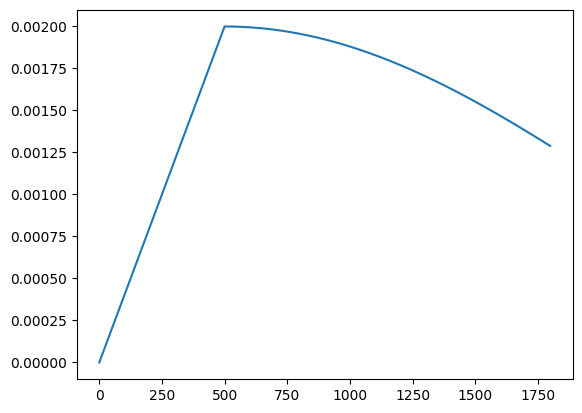

In [20]:
import matplotlib.pyplot as pl
%matplotlib inline
pl.figure()
pl.plot(lr_test)


In [2]:
device_id = torch.device("cuda")
ndim_diff = Nmax - 1

lgM_array = np.linspace(lgMmin, lgMmax, 1000)
M_array = 10**lgM_array
if '200c' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = '200c', model = 'tinker08', q_out = 'dndlnM')
if 'vir' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = 'vir', model = 'tinker08', q_out = 'dndlnM')    
if 'fof' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = 'fof', model = 'bhattacharya11', q_out = 'dndlnM')
lgM_rescaled = rescale_sub + (lgM_array - lgMmin)/(lgMmax-lgMmin)

int_val = sp.integrate.simps(hmf, lgM_rescaled)
hmf_pdf = hmf/int_val
# define the cdf of the halo mass function
hmf_cdf = np.zeros_like(hmf_pdf)
for i in range(len(hmf_cdf)):
    hmf_cdf[i] = sp.integrate.simps(hmf_pdf[:i+1], lgM_rescaled[:i+1])

if 'sigv' in config:
    sigv = config['sigv']
else:
    sigv = 0.05
num_cond_Ntot = num_cond
mu_all = np.arange(Nmax + 1) + 1
sig_all = sigv * np.ones_like(mu_all)
ngauss_Nhalo = Nmax + 1

model_BinaryMask = SumGaussModel(
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_Ntot,
    ngauss=2,
    mu_all=mu_all[:2],
    sig_all=sig_all[:2],
    base_dist=base_dist_Ntot,
    device=device_id
    )

# model_BinaryMask.to(dev)


model_multiclass = SumGaussModel(
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_Ntot,
    ngauss=ngauss_Nhalo - 1,
    mu_all=mu_all[1:] - 1,
    sig_all=sig_all[1:],
    base_dist=base_dist_Ntot,
    device=device_id
    )


# model_multiclass.to(dev)


num_cond_M1 = num_cond + 1
# # if conditioned on fastpm we will also give the fastpm fof M1 halos and its mask as conditional
# if cond_sim == 'fastpm':
#     num_cond_M1 += 2

model_M1 = NSF_1var_CNNcond(
    K=K_M1,
    B=B_M1,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_M1,
    nflows=nflows_M1_NSF,
    base_dist=base_dist_M1,
    ngauss=ngauss_M1,
    lgM_rs_tointerp=lgM_rescaled,
    hmf_pdf_tointerp=hmf_pdf,
    hmf_cdf_tointerp=hmf_cdf,
    device=device_id 
    )

ndim_diff = Nmax - 1
num_cond_Mdiff = num_cond + 2
model_Mdiff = NSF_Autoreg_CNNcond(
    dim=ndim_diff,
    K=K_Mdiff,
    B=B_Mdiff,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_Mdiff,
    nflows=nflows_Mdiff_NSF,
    base_dist=base_dist_Mdiff,
    mu_pos=True
    )


ndim = ndim_diff + 1
model = COMBINED_Model(
    None,
    model_Mdiff,
    # None,
    model_M1,
    model_BinaryMask,
    model_multiclass,
    ndim,
    ksize,
    ns_d,
    ns_h,
    1,
    ninp,
    nfeature_cnn,
    nout_cnn,
    layers_types=layers_types,
    act='tanh',
    padding='valid',
    sep_Binary_cond=True,
    sep_MultiClass_cond=True,
    sep_M1_cond=True,
    sep_Mdiff_cond=True,
    num_cond_Binary = num_cond_Ntot,
    num_cond_MultiClass = num_cond_Ntot,
    num_cond_M1 = num_cond_M1,
    num_cond_Mdiff = num_cond_Mdiff
    ).to(device_id)

# model = DDP(model, device_ids=[device_id], find_unused_parameters=True)

model = torch.nn.DataParallel(model)


/tmp/ipykernel_1445369/2105000535.py:14: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  int_val = sp.integrate.simps(hmf, lgM_rescaled)
/tmp/ipykernel_1445369/2105000535.py:19: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  hmf_cdf[i] = sp.integrate.simps(hmf_pdf[:i+1], lgM_rescaled[:i+1])


In [3]:
ldir_cp = '/mnt/home/spandey/ceph/CHARM/model_checkpoints/test0/'

checkpoint = torch.load(ldir_cp + f'test_model_bestfit_5600.pth', map_location=device_id)
# print(iter)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
print()


In [14]:
test_id = 1855

ldir_f = '/mnt/home/spandey/ceph/Quijote/data_NGP_self_fastpm_LH/'

n_dim_red = (nf - 1) // 2
n_pad = n_dim_red * nc

df_zg = pk.load(open(ldir_f + '%d/density_HR_full_m_res_128_z=0.5_nbatch_8_nfilter_3_ncnn_0.pk'%test_id,'rb'))
df_test_zg = df_zg['density_cic_unpad_combined']
df_test_pad_zg = np.pad(df_test_zg, n_pad, 'wrap')



z_REDSHIFT = float(z_all_FP[-1].split('_')[1])
if z_REDSHIFT == 0.0:
    z_REDSHIFT = 0

df_load = pk.load(open(
    ldir_f + '/' + str(test_id) + '/velocity_HR_full_m_res_128_z=' + str(z_REDSHIFT) + '_nbatch_8_nfilter_3_ncnn_0.pk', 'rb')
    )

vel_all = df_load['velocity_cic_unpad_combined']
# # vel_pad_all = 
vel_pad = np.stack([np.pad(vel_all[j,...], n_pad, 'wrap') for j in range(3)], axis=0)

df_test_all_pad = np.concatenate([np.log(1 + df_test_pad_zg + 1e-10)[None,...], vel_pad], axis=0)[None, None,:]
# df_test_all_pad = np.stack([np.log(1 + df_test_pad_zg + 1e-10), np.log(
#     1 + df_test_pad_zIC + 1e-10), df_test_pad_constrast_zg], axis=0)[None, None, :]

# df_test_all_pad.shape

# density_smoothed = gaussian_filter(df_test_zg, sigma=VALUE_SIG)
# df_test_constrast_zg = density_smoothed - df_test_zg
# 
df_test_all_unpad = np.concatenate([np.log(1 + df_test_zg + 1e-10)[None,...], vel_all], axis=0)[None, None,:]
# df_test_all_unpad = np.stack([np.log(1 + df_test_zg + 1e-10), np.log(
#     1 + df_test_zIC + 1e-10), df_test_constrast_zg], axis=0)[None, None, :]

# df_test_all_unpad.shape

cond_nsh_test = np.moveaxis(df_test_all_unpad, 2, 5)
nsims_test = cond_nsh_test.shape[1]
nax_h_test = cond_nsh_test.shape[2]
ninp_test = cond_nsh_test.shape[-1]
cond_tensor_nsh_test = torch.Tensor(np.copy(cond_nsh_test.reshape(1,nsims_test * (nax_h_test ** 3), ninp_test))).cuda(device_id)    

# cond_tensor_nsh_test.shape
LH_cosmo_val_file='/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt'
LH_cosmo_val_all = np.loadtxt(LH_cosmo_val_file)
fid_cosmo_val_all = LH_cosmo_val_all[test_id]
# fid_cosmo_val_all = np.array([0.3175, 0.049, 0.6711, 0.9624, 0.64])  

cosmo_val_test = np.tile(fid_cosmo_val_all, (cond_tensor_nsh_test.shape[1] ,1))[None,:]

# cosmo_val_test.shape
# df_test_all_pad.shape, df_test_all_unpad.shape, cosmo_val_test.shape
df_test_all_pad = torch.tensor(df_test_all_pad).to(device_id)
df_test_all_unpad = torch.tensor(cond_tensor_nsh_test).to(device_id)
cosmo_val_test = torch.tensor(cosmo_val_test, dtype=torch.float32).to(device_id)




/tmp/ipykernel_1445369/1384930048.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df_test_all_unpad = torch.tensor(cond_tensor_nsh_test).to(device_id)


In [15]:
train_Ntot, train_M1, train_Mdiff = 1, 1, 1
train_binary, train_multi = 1, 1
# if verbose:
    # print(f"Running the model")

# run the model
Ntot_samp_test, M1_samp_test, M_diff_samp_test, mask_tensor_M1_samp_test, mask_tensor_Mdiff_samp_test, _ = model.module.inverse(
    cond_x=df_test_all_pad,
    cond_x_nsh=df_test_all_unpad,
    cond_cosmo=cosmo_val_test,
    use_truth_Nhalo=1-train_Ntot,
    use_truth_M1=1-train_M1,
    use_truth_Mdiff=1-train_Mdiff,
    mask_Mdiff_truth=None,
    mask_M1_truth=None,
    Nhalos_truth=None,
    M1_truth=None,
    Mdiff_truth=None,
    train_binary=train_binary,
    train_multi=train_multi,
    train_M1=train_M1,
    train_Mdiff=train_Mdiff,
)




In [16]:
BoxSize=1000
# Ntot_samp_test[0].shape
Ntot_samp_test_rs = Ntot_samp_test[0][:, np.newaxis]
M1_samp_test_rs = (M1_samp_test[0] * mask_tensor_M1_samp_test[0][:, 0]).cpu().detach().numpy()
M_diff_samp_test_rs = (M_diff_samp_test[0] * mask_tensor_Mdiff_samp_test[0]).cpu().detach().numpy()




Ntot_samp_test = Ntot_samp_test[0][:, np.newaxis]
save_subvol_Nhalo = Ntot_samp_test.reshape(
    nsims_test, nax_h_test, nax_h_test, nax_h_test)
save_subvol_M1 = (M1_samp_test[0] * mask_tensor_M1_samp_test[0][:, 0]
                    ).cpu().detach().numpy().reshape(nsims_test, nax_h_test, nax_h_test, nax_h_test, 1)
save_subvol_Mdiff = (M_diff_samp_test[0] * mask_tensor_Mdiff_samp_test[0]
                        ).cpu().detach().numpy().reshape(nsims_test, nax_h_test, nax_h_test, nax_h_test, ndim_diff)

mask_subvol_Mtot1 = mask_tensor_M1_samp_test[0].cpu().detach().numpy().reshape(
    nsims_test, nax_h_test, nax_h_test, nax_h_test)[..., None]
mask_subvol_Mtot2 = mask_tensor_Mdiff_samp_test[0].cpu().detach().numpy(
).reshape(nsims_test, nax_h_test, nax_h_test, nax_h_test, ndim_diff)
mask_subvol_Mtot = np.concatenate(
    [mask_subvol_Mtot1, mask_subvol_Mtot2], axis=-1)

# compute the mass of halos from output
save_subvol_Mtot = np.zeros(
    (nsims_test, nax_h_test, nax_h_test, nax_h_test, ndim_diff + 1))
# Mmin, Mmax = return_dict_test['Mmin'], return_dict_test['Mmax']
for jd in range(ndim_diff + 1):
    if jd == 0:
        save_subvol_Mtot[..., jd] = (
            save_subvol_M1[..., 0] + 0.5) * (lgMmax - lgMmin) + lgMmin
    else:
        save_subvol_Mtot[...,
                            jd] = (save_subvol_Mtot[..., jd - 1]) - (save_subvol_Mdiff[..., jd - 1]) * (lgMmax - lgMmin)

save_subvol_Mtot *= mask_subvol_Mtot

Nhalos = save_subvol_Nhalo[0, ...]  # histogram of halos in each voxel
M_halos = save_subvol_Mtot[0, ...]  # mass of halos in each voxel

# create the meshgrid
xall = (np.linspace(0, BoxSize, ns_h + 1))
xarray = 0.5 * (xall[1:] + xall[:-1])
yarray = np.copy(xarray)
zarray = np.copy(xarray)
x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')

# record discrete halo positions and masses
x_h_mock, y_h_mock, z_h_mock, lgM_mock = [], [], [], []
# Nmax_sel = 3
k = 0
for jx in range(ns_h):
    for jy in range(ns_h):
        for jz in range(ns_h):
            Nh_vox = int(Nhalos[jx, jy, jz])
            if Nh_vox > 0:
                x_h_mock.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
                y_h_mock.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
                z_h_mock.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))

                lgM_mock.append((M_halos[jx, jy, jz, :Nh_vox]))
                k += Nh_vox

# convert to numpy arrays
x_h_mock = np.concatenate(x_h_mock)
y_h_mock = np.concatenate(y_h_mock)
z_h_mock = np.concatenate(z_h_mock)
pos_h_mock = np.vstack((x_h_mock, y_h_mock, z_h_mock)).T
lgMass_mock = np.concatenate(lgM_mock)
# convert to float data type
pos_h_mock = pos_h_mock.astype('float32')
lgMass_mock = lgMass_mock.astype('float32')





In [17]:
isim = test_id
# snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/fiducial_HR'
snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/latin_hypercube_HR'
snapnum = 3
MAS     = 'NGP'  #mass-assigment scheme
verbose = False   #print information on progress
snapdir = snap_dir_base + '/' + str(isim)  #folder hosting the catalogue
rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
    lines = f.readlines()
header = lines[0].split()
# get the properties of the halos
pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
index_M = header.index('M200c')                    
mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
lgMass_truth = np.log10(mass_truth).astype(np.float32)
vel_h_truth = rockstar[:,header.index('VX'):header.index('VZ')+1]

indsel = np.where(mass_truth > 5e12)[0]
pos_h_truth = pos_h_truth[indsel]
vel_h_truth = vel_h_truth[indsel]
lgMass_truth = lgMass_truth[indsel]




/tmp/ipykernel_1445369/3218459897.py:16: RuntimeWarning: divide by zero encountered in log10
  lgMass_truth = np.log10(mass_truth).astype(np.float32)


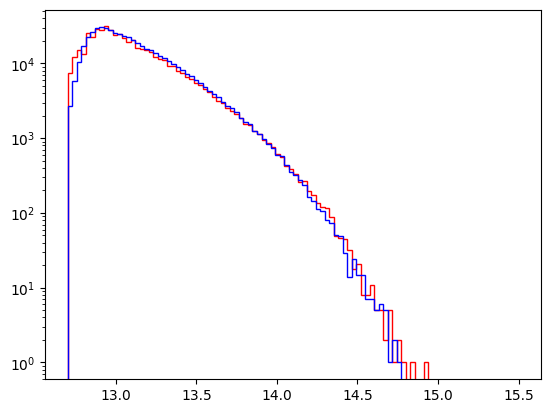

In [18]:
pl.figure()
_ = pl.hist(lgMass_truth, bins=100, histtype='step', color='r', label='truth', range=(12.7, 15.5))
_ = pl.hist(lgMass_mock, bins=100, histtype='step', color='b', label='mock', range=(12.7, 15.5))
pl.yscale('log')



In [19]:
import Pk_library as PKL
import MAS_library as MASL
grid_Pk_full = 128
MAS = 'NGP'
threads = 10
mesh_orig = np.zeros((grid_Pk_full, grid_Pk_full, grid_Pk_full), dtype=np.float32)
MASL.MA(pos_h_truth.astype(np.float32), mesh_orig, 1000., MAS)
mesh_orig /= np.mean(mesh_orig, dtype=np.float64);  mesh_orig -= 1.0
Pk_orig_real = PKL.Pk(mesh_orig, 1000., axis=0, MAS=MAS, threads=threads, verbose=False)

mesh_charm = np.zeros((grid_Pk_full, grid_Pk_full, grid_Pk_full), dtype=np.float32)
MASL.MA(pos_h_mock.astype(np.float32), mesh_charm, 1000., MAS)
mesh_charm /= np.mean(mesh_charm, dtype=np.float64);  mesh_charm -= 1.0
Pk_charm_real = PKL.Pk(mesh_charm, 1000., axis=0, MAS=MAS, threads=threads, verbose=False)



Text(0.5, 1.0, 'Real Pk, LH=1855')

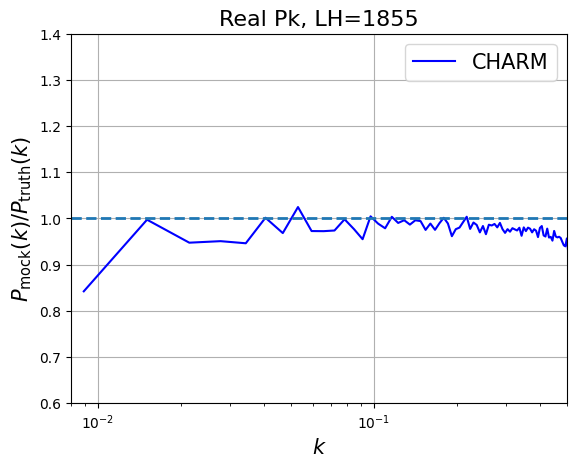

In [20]:
pl.figure()
# pl.plot(Pk_orig_rsd.k3D, Pk_pm_rsd.Pk[:,0]/Pk_orig_rsd.Pk[:,0], color='k', ls='-', alpha=1.0, label='FastPM')
pl.plot(Pk_orig_real.k3D, Pk_charm_real.Pk[:,0]/Pk_orig_real.Pk[:,0], color='b', ls='-', alpha=1.0, label='CHARM')
pl.axhline(1.0, ls='--', lw=2.0)
pl.xscale('log')
pl.ylim(0.6, 1.4)
pl.xlim(0.008, 0.5)
pl.xlabel(r'$k$', size=15)
pl.grid()
pl.legend(fontsize=15)
pl.ylabel(r'$P_{\rm mock}(k)/P_{\rm truth}(k)$', size=15)
pl.title(f'Real Pk, LH={test_id}', size=16)
# pl.savefig(sdirf + '/mono/' + f'NEW_monopole_Pk_{iter}.png', dpi=300,bbox_inches='tight')


